In [1]:
using Pkg
Pkg.instantiate()
using HTTP, JSON, JLD, Roots, PrettyTables, DotEnv
DEBUG_LEVEL = 1
using Optim, Random
Random.seed!(0)
using BlackBoxOptim, Distributions, ForwardDiff, Integrals, Roots, StatsPlots, DelimitedFiles
cfg = DotEnv.config("../.env")
files_path = cfg["files_path"]

┌ Warning: Error requiring `HTTP` from `BlackBoxOptim`
│   exception =
│    LoadError: ArgumentError: Package BlackBoxOptim does not have HTTP in its dependencies:
│    - You may have a partially installed environment. Try `Pkg.instantiate()`
│      to ensure all packages in the environment are installed.
│    - Or, if you have BlackBoxOptim checked out for development and have
│      added HTTP as a dependency but haven't updated your primary
│      environment's manifest file, try `Pkg.resolve()`.
│    - Otherwise you may need to report an issue with BlackBoxOptim
│    Stacktrace:
│      [1] macro expansion
│        @ ./loading.jl:1167 [inlined]
│      [2] macro expansion
│        @ ./lock.jl:223 [inlined]
│      [3] require(into::Module, mod::Symbol)
│        @ Base ./loading.jl:1144
│      [4] include(mod::Module, _path::String)
│        @ Base ./Base.jl:419
│      [5] include(x::String)
│        @ BlackBoxOptim ~/.julia/packages/BlackBoxOptim/lZtsr/src/BlackBoxOptim.jl:1
│      [6

"/home/peters/code/mapinator/estimation/current_estimates_and_files/"

In [2]:
raw_placement_rates = load(files_path*"adjusted_placement_rates.jld")["adjusted_placement_rates"]
row_index = 10
adjusted_placement_rates = vcat(raw_placement_rates[1:row_index-1,:],
    raw_placement_rates[row_index+1:size(raw_placement_rates)[1],:])
NUMBER_OF_TYPES = size(adjusted_placement_rates, 2)
numtotal = size(adjusted_placement_rates, 1)
adjusted_placement_rates

11×5 Matrix{Int64}:
 1417   476   299  100    0
 1139  1270   530  250   18
 1232  1863  1682  320   74
  323   733   758  965   96
    9    61    84   90  362
  664   775   481  143   45
  910   594   415  158   63
  100   206   235  133   65
   40    94   125  102  121
  244   233   161   72   20
  269   485   697  367  156

In [3]:
function F(x, ρ, μ, σ, K)
    return sum([ρ[i] * cdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function f(x, ρ, μ, σ, K)
    return sum([ρ[i] * pdf(truncated(Normal(μ[i], σ[i]), 0, 1), x) for i in 1:K])
end

function G(Fim1, Fx, αsum)
    return (Fim1 - Fx) / αsum
end

function κ(i, t, v_rel)
    return sum([-log(v_rel[j]) for j in t:i-1])
end

function fi(x, μ, σ)
    return pdf(truncated(Normal(μ, σ), 0, 1), x)
end

fi (generic function with 1 method)

In [4]:
function q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    # TODO: can some integrals be cached as a speed-up? can some integrals be computed in parallel?
    return sum([(α[t]/sum(α[1:s])) * solve(IntegralProblem{false}((x, p) -> exp(-(G(Fx_vec[s], F(x, ρ, μ, σ, K), sum(α[1:s])) + κ(s, t, v_rel))) * fi(x, μ[i], σ[i]), x_vec[s+1], x_vec[s]), HCubatureJL())[1] for s in t:k])
end

function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function Q2(ratio, β)
    return β * (1 - exp(-ratio)) / ratio
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

pi (generic function with 1 method)

In [5]:
function estimate_likelihood(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    #β = p_vec[end] # set = 1 to hardcode
    # a guess about how to kill the second round
    β = 0
    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    normalizer = 0.0

    q_it = zeros(K, k)
    for i in 1:K
        for t in 1:k
            prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
            q_it[i, t] = prob
            normalizer += ρ[i] * prob
        end
    end

    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    for i in 1:K
        for t in 1:k
            prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
            # println(sum([q_it[i, s] for s in 1:k]))
            # println(t, " ", i, " ", ρ[i] * (q_it[i, t] + prob), " ", ρ[i], " ", q_it[i, t], " ", (1 - sum([q_it[i, s] for s in 1:k])), " ", Q2(D/S, β), " ", α[t], " ", (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])), " ", S, " ", prob)
            objective += placements[i, t] * (log(ρ[i] * (q_it[i, t] + prob)))
            normalizer += ρ[i] * prob
        end
    end
    
    objective -= M * log(normalizer)
    return -objective
end

function print_metrics_maximum_likelihood(p_vec, placements, k, K, M)
    v_rel = p_vec[1:k-1]
    α = 1.0 * p_vec[k:2k-1] / sum(p_vec[k:2k-1]) # change 1.0 to scale number of graduates vs departments
    μ = p_vec[2k:2k+K-1]
    σ = p_vec[2k+K:2k+2K-1]
    ρ = p_vec[2k+2K:2k+3K-1] / sum(p_vec[2k+2K:2k+3K-1])
    β = p_vec[end] # set = 1 to hardcode

    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, μ, σ, K) - Fx_vec[t+1], 0.5) 
    end

    objective = 0.0
    likelihood = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    for i in 1:K, t in 1:k
        prob = q(i, t, Fx_vec, x_vec, ρ, μ, σ, α, v_rel, k, K)
        q_it[i, t] = prob
        normalizer += ρ[i] * prob
    end
    
    # TODO: div by zero and negative floating point in mean
    D = sum([ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    S = sum([α[t] * (1 - sum([ρ[i]*q_it[i, t] for i in 1:K])) for t in 1:k])
    round_2 = zeros(K, k)
    round_2_hiring = zeros(K, k)

    for i in 1:K, t in 1:k
        prob = (1 - sum([q_it[i, s] for s in 1:k])) * Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        round_2[i, t] = prob
        round_2_hiring[i, t] = Q2(D/S, β) * α[t] * (1 - sum([ρ[j] * q_it[j, t] for j in 1:K])) / S
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    exp_placements_round_1 = zeros(K, k)
    exp_placements_round_2 = zeros(K, k)
    exp_placements = zeros(K, k)
    for i in 1:K, t in 1:k 
        expectation = M * (ρ[i] * (q_it[i, t] + round_2[i, t]) / normalizer)
        exp_placements_round_1[i, t] = M * (ρ[i] * q_it[i, t] / normalizer)
        exp_placements_round_2[i, t] = M * (ρ[i] * round_2[i, t] / normalizer)
        exp_placements[i, t] = expectation
        objective += (placements[i, t] - expectation) ^ 2 / expectation
        likelihood += placements[i, t] * (log(ρ[i] * (q_it[i, t] + round_2[i, t])))
        likelihood -= log(factorial(big(placements[i, t])))
    end
    likelihood -= M * log(normalizer)

    println("chi-square objective value = ", objective)
    println("log-likelihood objective value = ", likelihood)
    println("likelihood objective value = ", exp(likelihood))
    println("success sample size (departments) = ", M)
    println("estimated total samples (departments) = ", M / normalizer)
    println("estimated unmatched departments = ", (M / normalizer) - M)
    println("probability of any success: ", normalizer)
    println("probability of no success: ", 1 - normalizer)
    println("measure of departments in round 2 = ", D)
    println("measure of graduates in round 2 = ", S)
    println()
    println("predicted fraction of departments of each tier:")
    display(ρ)
    println()
    println("fractions observed among successful departments in data:")
    display(sum(placements, dims = 2) ./ M)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Round 1 hiring probabilities:")
    display(q_it)
    println()

    println("Probabilities of failing round 1")
    display(round_1_failure)
    println()

    println("Probabilities of failing round 1 and hiring in round 2:")
    display(round_2)
    println()

    println("Round 2 hiring probabilities:")
    display(round_2_hiring)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (M / normalizer - 1))
        println("  Successful: ", sum(placements[:, i]))
        println("  Unsuccessful: ", (α[i] * (M / normalizer - 1)) - sum(placements[:, i]))
    end
    println("Total estimated graduates: ", sum(α) * (M / normalizer - 1))
    println("Total successful graduates: ", M)
    println("Total estimated unsuccessful graduates: ", (sum(α) * (M / normalizer - 1)) - M)
    println("β = ", β)
    println()
    println("estimated placement rates, round 1 only:")
    display(exp_placements_round_1)
    println()
    println("estimated placement rates, round 2 only:")
    display(exp_placements_round_2)
    println()
    println("estimated placement rates, cumulative:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective))
end

print_metrics_maximum_likelihood (generic function with 1 method)

In [6]:
k = NUMBER_OF_TYPES
K = numtotal
M = sum(adjusted_placement_rates)

# upper bound on the value ratios, which should all be less than 1
# if any ratio turns out to be 1.0 or close to it at optimality, this could indicate that a lower tier has a higher value than a higher one
upper = [1.0 for _ in 1:k-1] 

# upper bound on variables proportionate to alpha
append!(upper, [1.0 for _ in 1:k])

# upper bound on the mu parameter of truncated normal, which is strictly within [0, 1] as the mean is greater than mu in truncated normal
append!(upper, [1.0 for _ in 1:K])

# upper bound on the sigma parameter of truncated normal
append!(upper, [5.0 for _ in 1:K])

# upper bound on variables proportionate to rho
append!(upper, [1.0 for _ in 1:K])

# upper bound on beta friction parameter
push!(upper, 1.0)

# all lower bounds are zero as these should be positive parameters
# can swap estimate_likelihood for chi_square
sol_res = bboptimize(p -> estimate_likelihood(p, adjusted_placement_rates, k, K, M), SearchRange = [(0.0, upper[i]) for i in eachindex(upper)], MaxFuncEvals = 100000, TraceInterval = 5)
sol = best_candidate(sol_res)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.00 secs, 1108 evals, 604 steps, improv/step: 0.940 (last = 0.9404), fitness=NaN
10.01 secs, 2292 evals, 1247 steps, improv/step: 0.950 (last = 0.9596), fitness=NaN
15.01 secs, 3451 evals, 1871 steps, improv/step: 0.956 (last = 0.9679), fitness=NaN
20.02 secs, 4657 evals, 2558 steps, improv/step: 0.952 (last = 0.9389), fitness=NaN
25.02 secs, 5735 evals, 3160 steps, improv/step: 0.951 (last = 0.9485), fitness=NaN
30.03 secs, 6870 evals, 3766 steps, improv/step: 0.955 (last = 0.9769), fitness=NaN
35.04 secs, 7980 evals, 4386 steps, improv/step: 0.955 (last = 0.9565), fitness=NaN
40.04 secs, 9090 evals, 5004 steps, improv/step: 0.954 (last = 0.9482), fitness=NaN
45.05 secs, 10193 evals, 5628 steps, improv/step: 0.953 (last = 0.9455), fitness=NaN
50.06 secs, 11391 evals, 6265 steps, impr

43-element Vector{Float64}:
 0.6647461328472639
 0.1514860081224615
 0.8073870415730589
 0.04083939099150617
 0.5089940485647689
 0.3832520582242447
 0.6609022075774436
 0.8969462016339322
 0.1814193478169367
 0.7625975701459895
 0.5651838755551768
 0.3117771274312944
 0.8331932579875183
 ⋮
 0.46985165864858613
 0.8381800186516806
 0.27236591630875273
 0.2144567714571515
 0.6366626921247511
 0.906298884687009
 0.14610324933931906
 0.42177793138592057
 0.36967911640231377
 0.5263974285329932
 0.004562127372757407
 0.5219901071133062

In [7]:
# uncomment this after estimation if you want detailed estimates

# ensure the correct metrics function is used based on the selected optimizer
print_metrics_maximum_likelihood(sol, adjusted_placement_rates, k, K, M)


chi-square objective value = 262795.3728589156
log-likelihood objective value = -221661.2345718676703329394294555340486167947401780474553756139781239816319997984
likelihood objective value = 5.610138403722335691213498829398576609870190506685181484096341732518187962345617e-96267
success sample size (departments) = 22324
estimated total samples (departments) = 33831.2769037588
estimated unmatched departments = 11507.2769037588
probability of any success: 0.6598627673293558
probability of no success: 0.3401372326706442
measure of departments in round 2 = 0.5576739381612674
measure of graduates in round 2 = 0.908397733486601

predicted fraction of departments of each tier:


11-element Vector{Float64}:
 0.09775672751497037
 0.17439064901356113
 0.05666809976055426
 0.04461959809054751
 0.13246321507515668
 0.18856337204873694
 0.030398052814788263
 0.08775457008902351
 0.07691495812542185
 0.10952156715523761
 0.0009491903120018401


fractions observed among successful departments in data:


11×1 Matrix{Float64}:
 0.10266977244221466
 0.14365705070775847
 0.23163411574986562
 0.12878516394911307
 0.02714567281849131
 0.09442752194947142
 0.0958609568177746
 0.03310338648987637
 0.02159111270381652
 0.0327002329331661
 0.0884250134384519


pi_1 = 1.0
pi_2 = 0.42953626281820356
pi_3 = 0.4255242087727027
pi_4 = 0.3660863675978244
pi_5 = 0.06894105720338717

Tier selection probabilities for making offers:


5×5 Matrix{Float64}:
 1.0       0.0       0.0       0.0       0.0
 0.570464  0.429536  0.0       0.0       0.0
 0.327718  0.246758  0.425524  0.0       0.0
 0.207745  0.156423  0.269746  0.366086  0.0
 0.193423  0.145639  0.251149  0.340848  0.0689411


Round 1 hiring probabilities:


11×5 Matrix{Float64}:
 0.217002  0.152921  0.0524584  0.0285482  0.0
 0.179871  0.135537  0.0728621  0.0442307  0.0
 0.179783  0.127778  0.0832229  0.05716    0.0
 0.182565  0.128785  0.0819866  0.0561963  0.0
 0.181226  0.128148  0.0827787  0.0569245  0.0
 0.188418  0.1322    0.0777297  0.0520079  0.0
 0.180317  0.127809  0.0831957  0.0572572  0.0
 0.108809  0.100136  0.114686   0.0764529  0.0
 0.182017  0.128654  0.0821435  0.0562712  0.0
 0.187167  0.131537  0.0785521  0.0527821  0.0
 0.134883  0.111786  0.101857   0.0692497  0.0


Probabilities of failing round 1


11-element Vector{Float64}:
 0.5490704340343429
 0.5674999949263628
 0.5520553528646004
 0.5504676670215785
 0.5509231054139617
 0.5496449587590191
 0.5514214337448933
 0.5999155276640574
 0.5509141346595597
 0.549962395601843
 0.5822249355506897


Probabilities of failing round 1 and hiring in round 2:


11×5 Matrix{Float64}:
 0.0373912  0.0298555  0.0545113  0.0761678  0.0162548
 0.0386462  0.0308576  0.056341   0.0787244  0.0168004
 0.0375944  0.0300178  0.0548077  0.0765819  0.0163432
 0.0374863  0.0299315  0.0546501  0.0763616  0.0162962
 0.0375173  0.0299563  0.0546953  0.0764248  0.0163097
 0.0374303  0.0298868  0.0545684  0.0762475  0.0162718
 0.0375513  0.0299834  0.0547447  0.0764939  0.0163244
 0.0408537  0.0326202  0.0595592  0.0832211  0.0177601
 0.0375167  0.0299558  0.0546944  0.0764236  0.0163094
 0.0374519  0.029904   0.0545999  0.0762915  0.0162812
 0.039649   0.0316583  0.0578029  0.080767   0.0172363


Round 2 hiring probabilities:


11×5 Matrix{Float64}:
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043
 0.068099  0.0543747  0.0992793  0.138721  0.0296043


x_0 = 1.0
x_1 = 0.9167236008351827
x_2 = 0.29650232596045467
x_3 = 0.16892442590041204
x_4 = 0.0
x_5 = 0.0

F(x_0) = 1.0
F(x_1) = 0.9210159002576563
F(x_2) = 0.2811172443665797
F(x_3) = 0.1548403588380004
F(x_4) = 0.0

α_1 = 0.193422522131961
  Est. graduates: 6543.537483147656
  Successful: 6347
  Unsuccessful: 196.53748314765562
α_2 = 0.14563938404196425
  Est. graduates: 4927.020690232521
  Successful: 6790
  Unsuccessful: -1862.9793097674792
α_3 = 0.2511490502348051
  Est. graduates: 8496.441913559485
  Successful: 5467
  Unsuccessful: 3029.4419135594853
α_4 = 0.3408479863878826
  Est. graduates: 11530.98176159068
  Successful: 2700
  Unsuccessful: 8830.98176159068
α_5 = 0.06894105720338718
  Est. graduates: 2332.2950552284638
  Successful: 1020
  Unsuccessful: 1312.2950552284638
Total estimated graduates: 33830.27690375881
Total successful graduates: 22324
Total estimated unsuccessful graduates: 11506.276903758808
β = 0.5219901071133062

estimated placement rates, round 1 only:


11×5 Matrix{Float64}:
  717.675    505.747    173.492     94.4157   0.0
 1061.21     799.647    429.876    260.955    0.0
  344.673    244.971    159.551    109.585    0.0
  275.588    194.405    123.762     84.8305   0.0
  812.147    574.28     370.964    255.102    0.0
 1201.98     843.346    495.864    331.776    0.0
  185.439    131.439     85.5588    58.8836   0.0
  323.038    297.289    340.487    226.977    0.0
  473.632    334.775    213.748    146.425    0.0
  693.5      487.377    291.056    195.571    0.0
    4.33141    3.58969    3.27085    2.22377  0.0


estimated placement rates, round 2 only:


11×5 Matrix{Float64}:
 123.661     98.7393   180.282    251.905     53.7585
 228.007    182.056    332.404    464.463     99.1201
  72.0743    57.5488   105.075    146.819     31.3324
  56.587     45.1827    82.4963   115.271     24.5997
 168.13     134.246    245.111    342.49      73.0901
 238.781    190.658    348.11     486.409    103.804
  38.6179    30.835     56.2998    78.6668    16.7881
 121.288     96.8445   176.822    247.071     52.7269
  97.6234    77.9489   142.322    198.864     42.4392
 138.769    110.802    202.306    282.68      60.3261
   1.27322    1.01662    1.85619    2.59362    0.553499


estimated placement rates, cumulative:


11×5 Matrix{Float64}:
  841.336     604.486    353.774    346.321     53.7585
 1289.22      981.702    762.28     725.418     99.1201
  416.747     302.519    264.626    256.404     31.3324
  332.175     239.588    206.258    200.101     24.5997
  980.277     708.526    616.076    597.592     73.0901
 1440.76     1034.0      843.974    818.185    103.804
  224.057     162.274    141.859    137.55      16.7881
  444.327     394.133    517.309    474.048     52.7269
  571.255     412.724    356.07     345.289     42.4392
  832.269     598.179    493.362    478.251     60.3261
    5.60463     4.60632    5.12704    4.81739    0.553499


actual placement rates:


11×5 Matrix{Int64}:
 1417   476   299  100    0
 1139  1270   530  250   18
 1232  1863  1682  320   74
  323   733   758  965   96
    9    61    84   90  362
  664   775   481  143   45
  910   594   415  158   63
  100   206   235  133   65
   40    94   125  102  121
  244   233   161   72   20
  269   485   697  367  156


difference between estimated and actual placement rates:


11×5 Matrix{Float64}:
 -575.664      128.486     54.774   246.321     53.7585
  150.218     -288.298    232.28    475.418     81.1201
 -815.253    -1560.48   -1417.37    -63.5961   -42.6676
    9.17517   -493.412   -551.742  -764.899    -71.4003
  971.277      647.526    532.076   507.592   -288.91
  776.762      259.004    362.974   675.185     58.8035
 -685.943     -431.726   -273.141   -20.4497   -46.2119
  344.327      188.133    282.309   341.048    -12.2731
  531.255      318.724    231.07    243.289    -78.5608
  588.269      365.179    332.362   406.251     40.3261
 -263.395     -480.394   -691.873  -362.183   -155.447


chi-square p-value
0.0


In [8]:
v_base = 1
type_values = []
type_headers = []
row_names = ["Graduate Values"]
for i in 1:k
 #   println("v", i, ": ", v_base)
    push!(type_values, v_base)
    push!(type_headers, string("Tier ", i))
    if i != k
        v_base = sol[i] * v_base
    end
end
data = Vector{Float64}(type_values)
head = Vector{String}(type_headers)
#println(size(data,2), " " , size(data,1))
#println(Vector{String}(type_headers))
#println(row_names)
#pretty_table(data', header = head, row_names=row_names)
means_by_type = []
std_by_type = []
for select_type in 1:k
    push!(means_by_type, mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0 ,1)))
    push!(std_by_type, std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0 ,1)))
   
    #println("mean for type ", select_type, ": ", mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    #println("stddev for type ", select_type, ": ", std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
    #println()
end
datam = Vector{Float64}(means_by_type)
datas = Vector{Float64}(std_by_type)
shares = 1.0 * sol[k:2k-1] / sum(sol[k:2k-1]) # change 1.0 to scale number of graduates vs departments
all_data = hcat(data, datam, datas, shares )
push!(row_names, "Mean offer value")
push!(row_names, "Offers, std deviation")
push!(row_names, "Tier Shares")

#println(all_data)    
pretty_table(all_data', header = head, row_labels=row_names)

#for select_type in k+1:K
#    println("mean for sink ", select_type - k, ": ", mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
#    println("stddev for sink ", select_type - k, ": ", std(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
#    println()
#end

┌───────────────────────┬──────────┬──────────┬──────────┬───────────┬────────────┐
│                       │   Tier 1 │   Tier 2 │   Tier 3 │    Tier 4 │     Tier 5 │
├───────────────────────┼──────────┼──────────┼──────────┼───────────┼────────────┤
│       Graduate Values │      1.0 │ 0.664746 │   0.1007 │ 0.0813037 │ 0.00332039 │
│      Mean offer value │ 0.578468 │ 0.516514 │  0.49775 │  0.501864 │   0.499512 │
│ Offers, std deviation │ 0.262823 │ 0.272226 │ 0.287977 │  0.288348 │   0.288476 │
│           Tier Shares │ 0.193423 │ 0.145639 │ 0.251149 │  0.340848 │  0.0689411 │
└───────────────────────┴──────────┴──────────┴──────────┴───────────┴────────────┘


In [9]:
save(files_path*"current_estimates.jld", "all_data", all_data)

In [10]:
open(files_path*"current_estimates.tex", "w") do f
pretty_table(
    f,
    all_data',
    header = head,
        row_labels = row_names,
    backend = Val(:latex)
    )
end

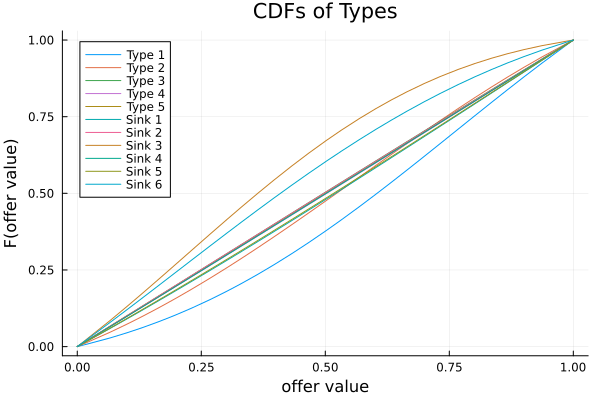

In [11]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/

select_type = 1
cdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(cdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = cdf, label = string("Sink ", select_type - k))
end
xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
savefig(cdfs, "cdfs.png")
cdfs

In [12]:
expected_offers = []
for select_type in 1:K
     push!(expected_offers,mean(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1)))
end
expected_offers
save(files_path*"expected_offers.jld", "expected_offers", expected_offers)

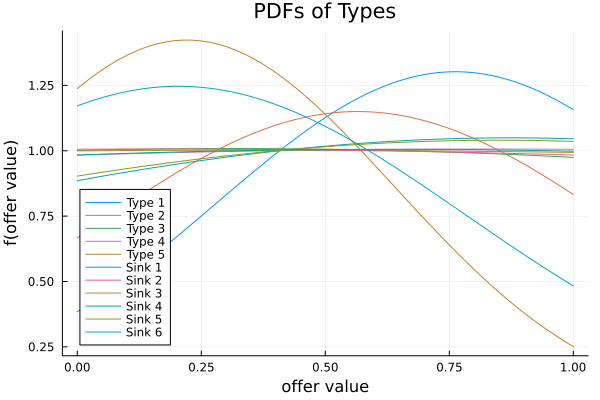

In [13]:
select_type = 1
pdfs = plot(truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:k # academic types
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, 
        label = string("Type ", select_type))
end

for select_type in k+1:K # sinks
    plot!(pdfs, truncated(Normal(sol[2k-1+select_type], sol[2k-1+select_type+K]), 0, 1), func = pdf, label = string("Sink ", select_type - k))
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
savefig(pdfs, "pdfs.png")
pdfs